In [1]:
from google.cloud import bigquery
import os
import pandas as pd
import plotly.express as px
import sys

sys.path.append('../../../visualizations/')
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = '../../../gcp_credentials.json'

from venn_diagram import venn3_diagram

client = bigquery.Client()

# Get projects by cohort

In [2]:
query = """
    select
      project_id,
      project_name,
      collection_name
    from `opensource-observer.oso.projects_by_collection_v1`
    where collection_name in ('op-rpgf3', 'op-rpgf2', 'op-retrofunding-4')
"""
projects_by_collection = client.query(query).to_dataframe()

In [3]:
collections = {}
for _,row in projects_by_collection.iterrows():
    c = row['collection_name'] 
    if c not in collections:
        collections.update({c:[]})
    collections[c].append(row['project_id'])
collections = {x:set(y) for x,y in collections.items()}

In [4]:
projects = (
    projects_by_collection[['project_id', 'project_name']]
    .drop_duplicates()
    .set_index('project_id')['project_name']
    .to_dict()
)
project_list = list(projects.keys())
project_list_str = "'" + "','".join(project_list) + "'"
len(project_list)

524

In [33]:
for pid,pname in projects.items():
    if pname in ['layer3xyz', 'multicaller-vectorized']:
        collections['op-rpgf3'].add(pid)

# Get project events

In [5]:
query = f"""
    select
      project_id,
      bucket_month,
      event_source,
      event_type,
      sum(amount) as amount
    from `opensource-observer.oso.int_events_monthly_to_project`
    where
      bucket_month > '2023-01-01' and bucket_month < '2024-07-01'
      and event_type in (
          'CONTRACT_INVOCATION_DAILY_L2_GAS_USED',
          'CONTRACT_INVOCATION_SUCCESS_DAILY_COUNT',
          'COMMIT_CODE'
      )
      and project_id in ({project_list_str})
    group by 1,2,3,4
"""
events_results = client.query(query)

In [6]:
events_by_project = events_results.to_dataframe()
events_by_project.head(1)

,project_id,bucket_month,event_source,event_type,amount
0,w3cYd84PoRdRJ0aJSg_A5Fn_WPpCROPaeq403DjEOAg=,2023-04-01 00:00:00+00:00,OPTIMISM,CONTRACT_INVOCATION_DAILY_L2_GAS_USED,6.154334e+15


# Visualize projects set membership

(<Figure size 1440x1440 with 1 Axes>, <Axes: >)

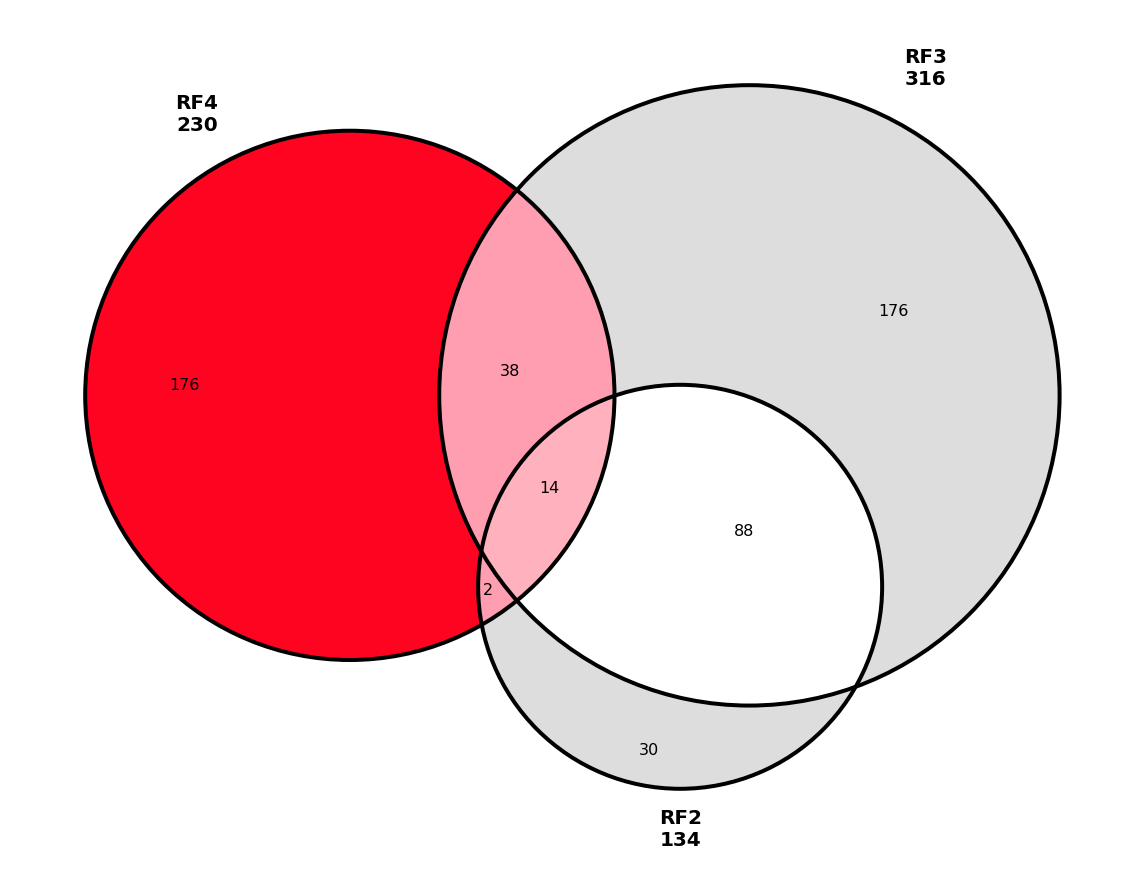

In [34]:
venn3_diagram(
    subsets=[
        collections['op-retrofunding-4'],
        collections['op-rpgf3'],
        collections['op-rpgf2']
    ],
    labels=[
        f"RF4\n{len(collections['op-retrofunding-4'])}",
        f"RF3\n{len(collections['op-rpgf3'])}",
        f"RF2\n{len(collections['op-rpgf2'])}"
    ],
    colors=[
        '#FF0420',
        '#DDD',
        '#DDD'
    ]
)

In [35]:
txns_by_project = (
    events_by_project[events_by_project['event_type'] == 'CONTRACT_INVOCATION_SUCCESS_DAILY_COUNT']
    .groupby('project_id')
    ['amount'].sum()
)
onchain_projects = set(txns_by_project[txns_by_project>420].index)
len(onchain_projects)

272

(<Figure size 1440x1440 with 1 Axes>, <Axes: >)

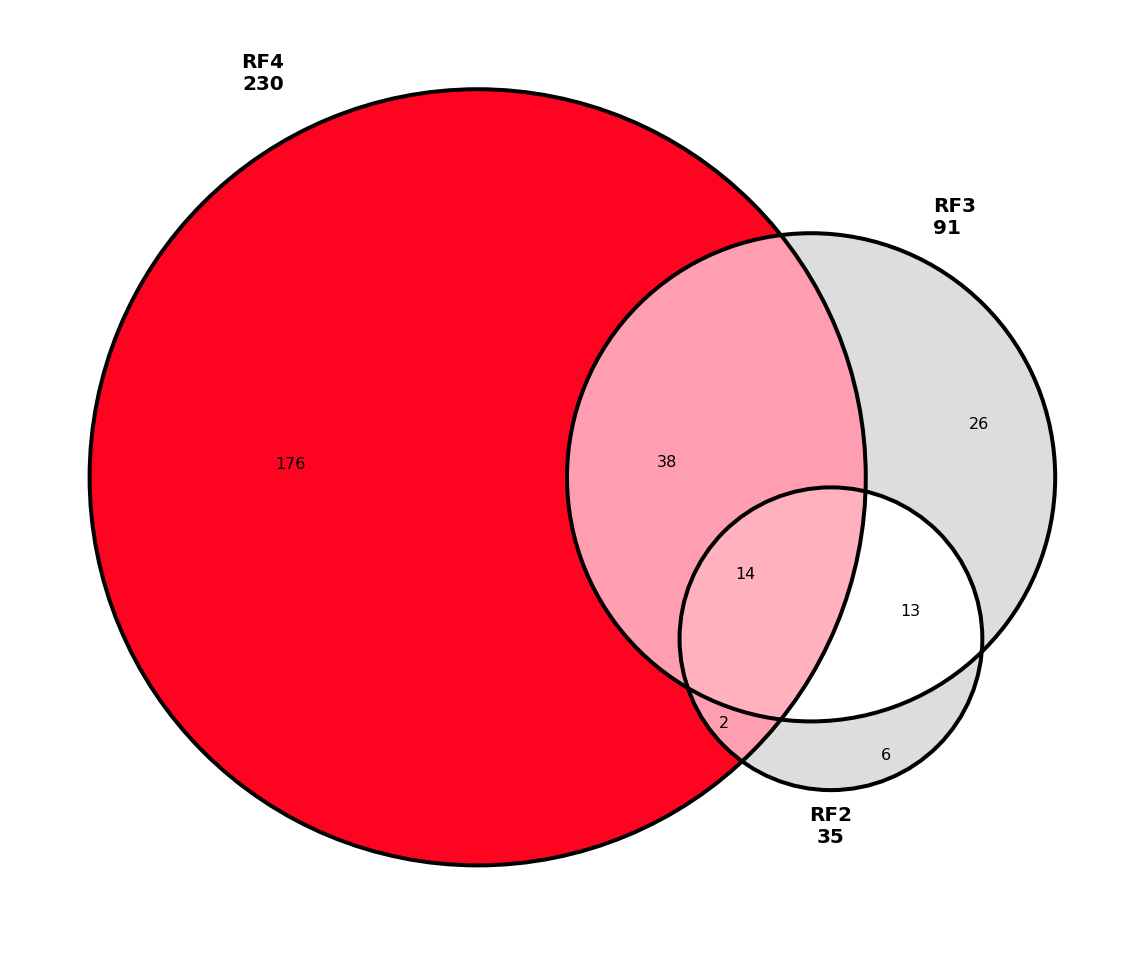

In [36]:
venn3_diagram(
    subsets=[
        collections['op-retrofunding-4'],
        collections['op-rpgf3'].intersection(onchain_projects),
        collections['op-rpgf2'].intersection(onchain_projects)
    ],
    labels=[
        f"RF4\n{len(collections['op-retrofunding-4'])}",
        f"RF3\n{len(collections['op-rpgf3'].intersection(onchain_projects))}",
        f"RF2\n{len(collections['op-rpgf2'].intersection(onchain_projects))}"
    ],
    colors=[
        '#FF0420',
        '#DDD',
        '#DDD'
    ]
)

# Analyze cohort performance

In [37]:
df = events_by_project.copy()

df['event_type'] = df['event_type'].map({
    'COMMIT_CODE': 'Code Commits (K)', 
    'CONTRACT_INVOCATION_SUCCESS_DAILY_COUNT': 'Transactions (M)',
    'CONTRACT_INVOCATION_DAILY_L2_GAS_USED': 'Gas Fees (ETH)'
})
df.update(df[df['event_type'] == 'Gas Fees (ETH)']['amount'] / (10**18))
df.update(df[df['event_type'] == 'Transactions (M)']['amount'] / 1_000_000)
df.update(df[df['event_type'] == 'Code Commits (K)']['amount'] / 1_000)

df['project_name'] = df['project_id'].map(projects)
df['in_rf4'] = df['project_id'].apply(lambda x: x in collections['op-retrofunding-4'])

df.head()

,project_id,bucket_month,event_source,event_type,amount,project_name,in_rf4
0,w3cYd84PoRdRJ0aJSg_A5Fn_WPpCROPaeq403DjEOAg=,2023-04-01 00:00:00+00:00,OPTIMISM,Gas Fees (ETH),0.006154,galxe,False
1,iCKGtNOhEODQBvv6hcfWklD3P_3tOipTR10x1Yx-qkg=,2023-04-01 00:00:00+00:00,OPTIMISM,Transactions (M),0.013582,pool-together,True
2,o7Tegl37mRn3t51qS50mf-ENGA98ACIQV01Ae_NWWf0=,2023-04-01 00:00:00+00:00,OPTIMISM,Gas Fees (ETH),0.459242,0xproject,True
3,7gqfws0MWRPiMksDMMfnZZFhU66gzItyl2x5wJa6mEE=,2023-04-01 00:00:00+00:00,OPTIMISM,Gas Fees (ETH),0.027041,socket,False
4,jEwXVxDdBJ7TGKYlbAWvoLKqCjFY_iuzY7PabwtIoF8=,2023-04-01 00:00:00+00:00,OPTIMISM,Gas Fees (ETH),0.006963,voteagora,False


In [38]:
def assign_cohort(project_id):
    round_list = []
    for c,lst in collections.items():
        if project_id in lst:
            rnd = c[-1]
            round_list.append(rnd)
    return 'RF'+'/'.join(sorted(round_list))

df['cohort'] = df['project_id'].apply(assign_cohort)
df['cohort_label'] = df['cohort'].map({
    'RF4': 'RF4 only',
    'RF3/4': 'Multiple RFs',
    'RF2/3/4': 'Multiple RFs',
    'RF2/4': 'Multiple RFs',    
    'RF3': 'Past RFs only',
    'RF2/3': 'Past RFs only',
    'RF2': 'Past RFs only'
})


def assign_month(bucket_month):
    month = f'{bucket_month.year}-{str(bucket_month.month).zfill(2)}'
    if month >= '2024-06':
        return 'Post RF4'
    elif month >= '2023-10':
        return 'RF4 window'
    elif month >= '2023-02':
        return 'RF3 window'
    else:
        return 'Other'
    
df['time_interval'] = df['bucket_month'].apply(assign_month)

df.head(1)

,project_id,bucket_month,event_source,event_type,amount,project_name,in_rf4,cohort,cohort_label,time_interval
0,w3cYd84PoRdRJ0aJSg_A5Fn_WPpCROPaeq403DjEOAg=,2023-04-01 00:00:00+00:00,OPTIMISM,Gas Fees (ETH),0.006154,galxe,False,RF3,Past RFs only,RF3 window


In [39]:
px.treemap(
    data_frame=df[
        (df['event_type'] == 'Gas Fees (ETH)')
         & (df['time_interval'] == 'RF4 window')
         & (df['in_rf4']==True)
    ].dropna(),
    path=['cohort_label', 'project_name'],
    values='amount',
    color_discrete_sequence=['#FF0420', '#DDD'],
    
)

In [40]:
txns = (
    df[df['event_type'] == 'Transactions (M)']
    .groupby(['bucket_month','cohort_label'])
    ['amount'].sum()
    .reset_index()
)
txns.head(1)

,bucket_month,cohort_label,amount
0,2023-02-01 00:00:00+00:00,Multiple RFs,0.657073


In [56]:
fig = px.area(
    data_frame=txns,
    x='bucket_month',
    y='amount',
    color='cohort_label',
    color_discrete_sequence=['purple', 'cyan', '#FF0420'],
)
fig.update_layout(
    xaxis=dict(showgrid=True, title=''),
    yaxis=dict(showgrid=True, title='Superchain Transactions (M)'),
    legend=dict(title='Cohort'),
    plot_bgcolor='white',
    paper_bgcolor='white'
)
fig.update_traces(line=dict(width=1))

In [16]:
(
    df[
        (df['time_interval'].isin(['RF4 window', 'RF3 window']))
        & (df['project_id'].isin(onchain_projects))
      ]
    .pivot_table(
        index='cohort_label',
        columns=['event_type', 'time_interval'],
        values='amount',
        aggfunc='sum')
    .applymap(round)
    .reindex(['RF4 only', 'Multiple RFs', 'Past RFs only'])
)

event_type    Code Commits (K)            Gas Fees (ETH)             \
time_interval       RF3 window RF4 window     RF3 window RF4 window   
cohort_label                                                          
RF4 only                    58         59            701       1349   
Multiple RFs                47         49            355       1018   
Past RFs only               24         21            119        109   

event_type    Transactions (M)             
time_interval       RF3 window RF4 window  
cohort_label                               
RF4 only                    33         58  
Multiple RFs                12         24  
Past RFs only               10          4

In [17]:
pvt = (
    df[
        (df['time_interval'].isin(['RF4 window', 'RF3 window']))
        & (df['project_id'].isin(onchain_projects))
      ]
    .pivot_table(
        index=['cohort_label', 'project_name'],
        columns=['event_type', 'time_interval'],
        values='amount',
        aggfunc='sum', 
        fill_value=0
    )
)

In [18]:
pvt

event_type                         Code Commits (K)            Gas Fees (ETH)  \
time_interval                            RF3 window RF4 window     RF3 window   
cohort_label project_name                                                       
Multiple RFs 0x-splits                        0.399      0.296       0.006573   
             across                           0.796      1.125       3.063905   
             aerodrome-finance                0.001      0.041       7.888162   
             buidlguidl                       0.709      1.483       0.000071   
             coordinape                       0.485      0.553       0.432166   
...                                             ...        ...            ...   
RF4 only     zerion                           0.034      0.185       0.571975   
             zerius-io                        0.000      0.030       0.000000   
             zkbob                            0.612      0.136       0.224327   
             zkp2p                            0.239      0.559       0.000000   
             zwergdev-whale-bridge            0.000      0.005       0.000000   

event_type                                     Transactions (M)             
time_interval                       RF4 window       RF3 window RF4 window  
cohort_label project_name                                                   
Multiple RFs 0x-splits                0.197686         0.000766   0.011147  
             across                  26.091997         0.124029   1.036695  
             aerodrome-finance      118.941636         0.302434   3.958043  
             buidlguidl               0.407910         0.000027   0.024952  
             coordinape               0.245044         0.042617   0.038769  
...                                        ...              ...        ...  
RF4 only     zerion                   3.962016         0.058307   0.121741  
             zerius-io                1.110249         0.000000   0.139076  
             zkbob                    0.377364         0.006254   0.018175  
             zkp2p                    0.031382         0.000000   0.001761  
             zwergdev-whale-bridge    0.428838         0.000000   0.038876  

[272 rows x 6 columns]

In [57]:
pvt

event_type                         Code Commits (K)            Gas Fees (ETH)  \
time_interval                            RF3 window RF4 window     RF3 window   
cohort_label project_name                                                       
Multiple RFs 0x-splits                        0.399      0.296       0.006573   
             across                           0.796      1.125       3.063905   
             aerodrome-finance                0.001      0.041       7.888162   
             buidlguidl                       0.709      1.483       0.000071   
             coordinape                       0.485      0.553       0.432166   
...                                             ...        ...            ...   
RF4 only     zerion                           0.034      0.185       0.571975   
             zerius-io                        0.000      0.030       0.000000   
             zkbob                            0.612      0.136       0.224327   
             zkp2p                            0.239      0.559       0.000000   
             zwergdev-whale-bridge            0.000      0.005       0.000000   

event_type                                     Transactions (M)             
time_interval                       RF4 window       RF3 window RF4 window  
cohort_label project_name                                                   
Multiple RFs 0x-splits                0.197686         0.000766   0.011147  
             across                  26.091997         0.124029   1.036695  
             aerodrome-finance      118.941636         0.302434   3.958043  
             buidlguidl               0.407910         0.000027   0.024952  
             coordinape               0.245044         0.042617   0.038769  
...                                        ...              ...        ...  
RF4 only     zerion                   3.962016         0.058307   0.121741  
             zerius-io                1.110249         0.000000   0.139076  
             zkbob                    0.377364         0.006254   0.018175  
             zkp2p                    0.031382         0.000000   0.001761  
             zwergdev-whale-bridge    0.428838         0.000000   0.038876  

[272 rows x 6 columns]